In [1]:
import struct
import math
import random

def ikeda_map(x, y, u):
  """Calculates the next (x, y) in the Ikeda map sequence."""
  t = 0.4 - (6 / (1 + x**2 + y**2))
  x_new = 1 + u * (x * math.cos(t) - y * math.sin(t))
  y_new = u * (x * math.sin(t) + y * math.cos(t))
  return x_new, y_new

def generate_ikeda_sequence(length, u=1, x0=None, y0=None):
  """
  Generates a randomized Ikeda sequence with slight variations in initial values
  and the parameter u to create unique sequences each time.
  """
  # Randomize initial conditions if not provided
  if x0 is None:
      x0 = random.uniform(-10.0, 10.0)
  if y0 is None:
      y0 = random.uniform(-10.0, 10.0)
  
  # Randomly perturb `u` slightly to add randomness
  u = random.uniform(0.8, 1.0)
  
  # Initialize the sequence with randomized starting points
  sequence = []
  x, y = x0, y0
  for _ in range(length):
      # Add a small random perturbation to `x` and `y`
      x += random.uniform(-0.1, 0.1)
      y += random.uniform(-0.1, 0.1)

      # Compute the next point in the Ikeda map
      x, y = ikeda_map(x, y, u)
      
      # Append the result to the sequence
      sequence.append((x, y))
      
  return sequence


def yield_chacha20_xor_stream(key, iv, position,ikeda_sequence):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)

  while 1:
      x = list(ctx)
      for i in range(10):
          quarter_round(x, 0, 4, 8, 12)
          quarter_round(x, 1, 5, 9, 13)
          quarter_round(x, 2, 6, 10, 14)
          quarter_round(x, 3, 7, 11, 15)
          quarter_round(x, 0, 5, 10, 15)
          quarter_round(x, 1, 6, 11, 12)
          quarter_round(x, 2, 7, 8, 13)
          quarter_round(x, 3, 4, 9, 14)

      if ikeda_sequence:
          # Modify the state based on Ikeda map values
          for j, (ix, iy) in enumerate(ikeda_sequence[:16]):
              x[j] = (x[j] + int(ix * 0xffffffff)) & 0xffffffff

      for c in struct.pack('<16L', *(x[i] + ctx[i] & 0xffffffff for i in range(16))):
          yield c

      ctx[12] = (ctx[12] + 1) & 0xffffffff
      if ctx[12] == 0:
          ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, ikeda_sequence,iv=None,position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position,ikeda_sequence)))

In [2]:
import matplotlib.pyplot as plt

# Display the encrypted and decrypted images side by side
def display_encrypted_and_decrypted_images(encrypted_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display encrypted image
    axes[0].imshow(encrypted_image)
    axes[0].set_title("Encrypted Image with Diffusion")
    axes[0].axis("off")

    # Display decrypted image
    axes[1].imshow(decrypted_image)
    axes[1].set_title("Decrypted Image with Diffusion")
    axes[1].axis("off")

    plt.show()

# Example usage



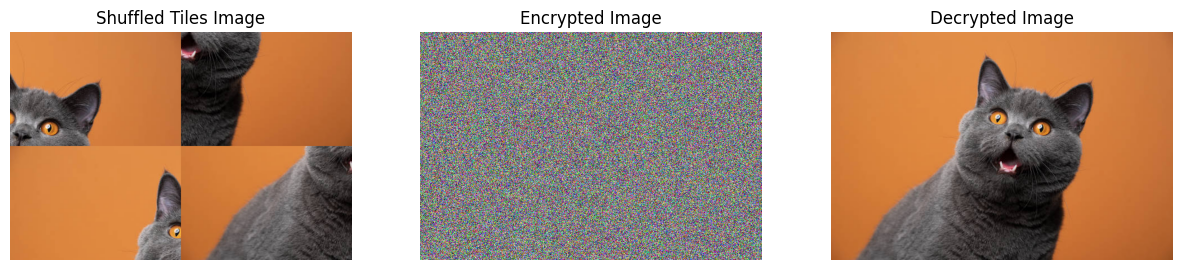

In [4]:
    import numpy as np
    from PIL import Image
    import random
    import matplotlib.pyplot as plt

    def split_image(image, rows, cols):
        """Splits an image into `rows` x `cols` regions."""
        width, height = image.size
        tile_width, tile_height = width // cols, height // rows
        tiles = [
            image.crop((j * tile_width, i * tile_height, (j + 1) * tile_width, (i + 1) * tile_height))
            for i in range(rows) for j in range(cols)
        ]
        return tiles

    def shuffle_tiles(tiles):
        """Shuffles tiles based on a key map."""
        key_map = list(range(len(tiles)))
        random.shuffle(key_map)
        shuffled_tiles = [tiles[i] for i in key_map]
        return shuffled_tiles, key_map

    def unshuffle_tiles(shuffled_tiles, key_map):
        """Reverses the shuffling using the key map."""
        tiles = [None] * len(shuffled_tiles)
        for i, index in enumerate(key_map):
            tiles[index] = shuffled_tiles[i]
        return tiles

    def encrypt_tile(tile, key, ikeda_sequence):
        """Encrypts a single tile using the modified ChaCha with Ikeda sequence."""
        tile_data = tile.tobytes()
        encrypted_data = chacha20_encrypt(tile_data, key, ikeda_sequence)
        encrypted_tile = Image.frombytes(tile.mode, tile.size, encrypted_data)
        return encrypted_tile

    def decrypt_tile(encrypted_tile, key, ikeda_sequence):
        """Decrypts a single tile using the modified ChaCha with Ikeda sequence."""
        encrypted_data = encrypted_tile.tobytes()
        decrypted_data = chacha20_encrypt(encrypted_data, key, ikeda_sequence)  # Symmetric encryption
        decrypted_tile = Image.frombytes(encrypted_tile.mode, encrypted_tile.size, decrypted_data)
        return decrypted_tile

    def merge_tiles(tiles, rows, cols, tile_width, tile_height):
        """Merges tiles back into a single image."""
        merged_image = Image.new('RGB', (cols * tile_width, rows * tile_height))
        for index, tile in enumerate(tiles):
            i, j = divmod(index, cols)
            merged_image.paste(tile, (j * tile_width, i * tile_height))
        return merged_image

    # Sample encryption and decryption pipeline
    def encrypt_image(image_path, key, ikeda_sequence, rows=2, cols=2):
        image = Image.open(image_path)
        tiles = split_image(image, rows, cols)
        shuffled_tiles, key_map = shuffle_tiles(tiles)
        encrypted_tiles = [encrypt_tile(tile, key, ikeda_sequence) for tile in shuffled_tiles]
        shuffled_image = merge_tiles(shuffled_tiles, rows, cols, tiles[0].size[0], tiles[0].size[1])
        encrypted_image = merge_tiles(encrypted_tiles, rows, cols, tiles[0].size[0], tiles[0].size[1])
        return shuffled_image, encrypted_image, key_map

    def decrypt_image(encrypted_image, key, ikeda_sequence, key_map, rows=2, cols=2):
        tiles = split_image(encrypted_image, rows, cols)
        decrypted_tiles = [decrypt_tile(tile, key, ikeda_sequence) for tile in tiles]
        unshuffled_tiles = unshuffle_tiles(decrypted_tiles, key_map)
        decrypted_image = merge_tiles(unshuffled_tiles, rows, cols, tiles[0].size[0], tiles[0].size[1])
        return decrypted_image

    # Example usage
    key = b'testkey'
    ikeda_sequence = generate_ikeda_sequence(20, u=0.9)  # Generate Ikeda sequence
    shuffled_image, encrypted_image, key_map = encrypt_image("cat.jpg", key, ikeda_sequence)
    decrypted_image = decrypt_image(encrypted_image, key, ikeda_sequence, key_map)

    # Display images using matplotlib
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Show shuffled image
    axes[0].imshow(shuffled_image)
    axes[0].set_title("Shuffled Tiles Image")
    axes[0].axis("off")

    # Show encrypted image
    axes[1].imshow(encrypted_image)
    axes[1].set_title("Encrypted Image")
    axes[1].axis("off")

    # Show decrypted image
    axes[2].imshow(decrypted_image)
    axes[2].set_title("Decrypted Image")
    axes[2].axis("off")

    plt.show()


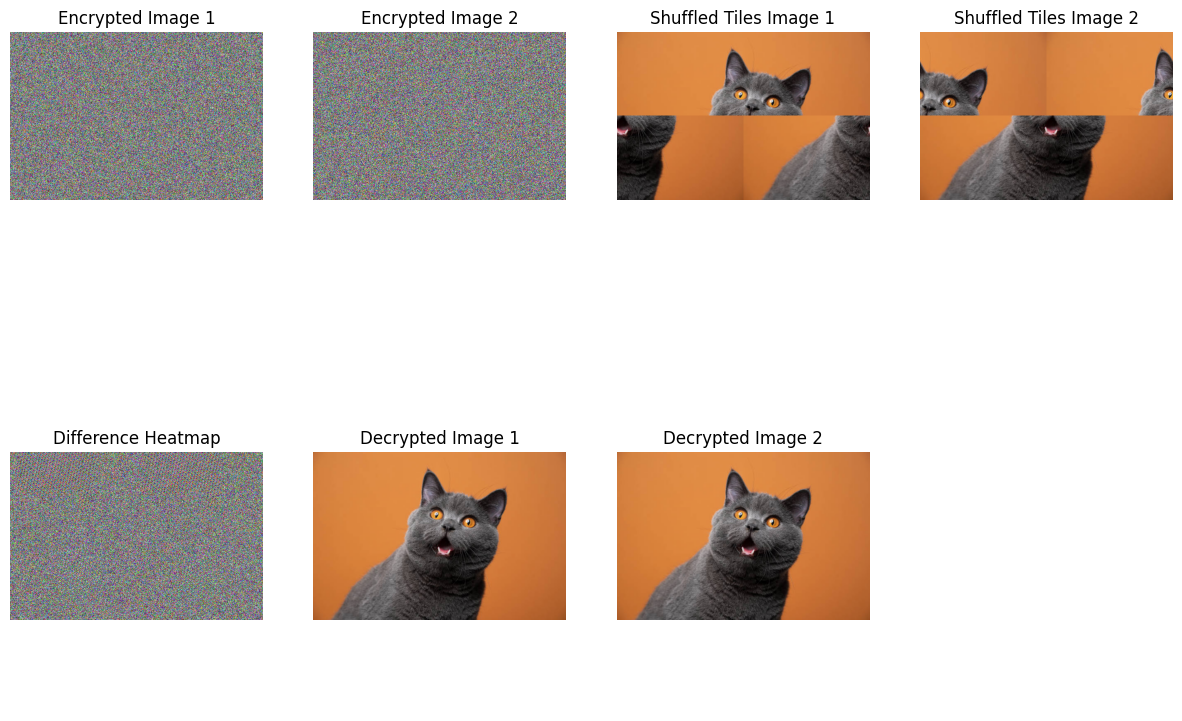

In [6]:
# Encrypt the same image with two different IVs
ikeda_sequence = generate_ikeda_sequence(20, u=0.9)  # Generate Ikeda sequence
ikeda_sequence1 = generate_ikeda_sequence(20, u=0.9)  # Generate Ikeda sequence

shuffled_image1, encrypted_image1, key_map1 = encrypt_image("cat.jpg", key, ikeda_sequence)
shuffled_image2, encrypted_image2, key_map2 = encrypt_image("cat.jpg", key, ikeda_sequence1)

# Compute the difference heatmap
img1_array = np.array(encrypted_image1)
img2_array = np.array(encrypted_image2)
difference = np.abs(img1_array - img2_array)

# Decrypt the images
decrypted_image1 = decrypt_image(encrypted_image1, key, ikeda_sequence, key_map1)
decrypted_image2 = decrypt_image(encrypted_image2, key, ikeda_sequence1, key_map2)

# Display the results
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Corrected indexing for axes[row, column]
axes[0, 0].imshow(encrypted_image1, cmap='gray')
axes[0, 0].set_title('Encrypted Image 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(encrypted_image2, cmap='gray')
axes[0, 1].set_title('Encrypted Image 2')
axes[0, 1].axis('off')

axes[0, 2].imshow(shuffled_image1)
axes[0, 2].set_title("Shuffled Tiles Image 1")
axes[0, 2].axis("off")

axes[0, 3].imshow(shuffled_image2)
axes[0, 3].set_title("Shuffled Tiles Image 2")
axes[0, 3].axis("off")

axes[1, 0].imshow(difference, cmap='hot')
axes[1, 0].set_title('Difference Heatmap')
axes[1, 0].axis('off')

axes[1, 1].imshow(decrypted_image1, cmap='gray')
axes[1, 1].set_title('Decrypted Image 1')
axes[1, 1].axis('off')

axes[1, 2].imshow(decrypted_image2, cmap='gray')
axes[1, 2].set_title('Decrypted Image 2')
axes[1, 2].axis('off')

axes[1, 3].axis('off')  # Hide last unused subplot

plt.show()


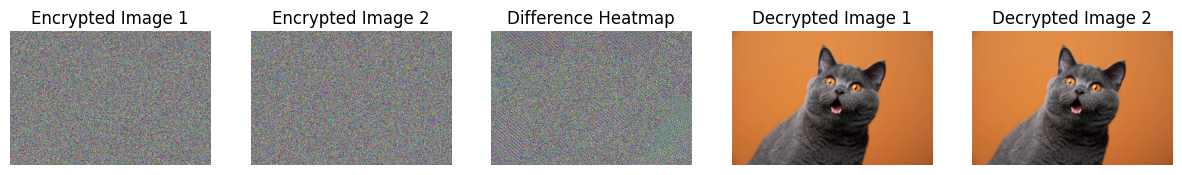

In [7]:
# Encrypt the same image with two different IVs
ikeda_sequence = generate_ikeda_sequence(20, u=0.9)  # Generate Ikeda sequence
ikeda_sequence1 = generate_ikeda_sequence(20, u=0.9)  # Generate Ikeda sequence

shuffled_image1,encrypted_image1, key_map1 = encrypt_image("cat.jpg", key, ikeda_sequence)
shuffled_image2,encrypted_image2, key_map2 = encrypt_image("cat.jpg", key ,ikeda_sequence1)

# Compute the difference heatmap
img1_array = np.array(encrypted_image1)
img2_array = np.array(encrypted_image2)
difference = np.abs(img1_array - img2_array)

# Decrypt the images
decrypted_image1 = decrypt_image(encrypted_image1, key, ikeda_sequence, key_map1)
decrypted_image2 = decrypt_image(encrypted_image2, key, ikeda_sequence1, key_map2)

# Display the results
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

# Display the first encrypted image
axes[0].imshow(encrypted_image1, cmap='gray')
axes[0].set_title('Encrypted Image 1')
axes[0].axis('off')

# Display the second encrypted image
axes[1].imshow(encrypted_image2, cmap='gray')
axes[1].set_title('Encrypted Image 2')
axes[1].axis('off')


# Display the difference heatmap
axes[2].imshow(difference, cmap='hot')
axes[2].set_title('Difference Heatmap')
axes[2].axis('off')

# Display the first decrypted image
axes[3].imshow(decrypted_image1, cmap='gray')
axes[3].set_title('Decrypted Image 1')
axes[3].axis('off')

# Display the second decrypted image
axes[4].imshow(decrypted_image2, cmap='gray')
axes[4].set_title('Decrypted Image 2')
axes[4].axis('off')


plt.show()

# Histogram             

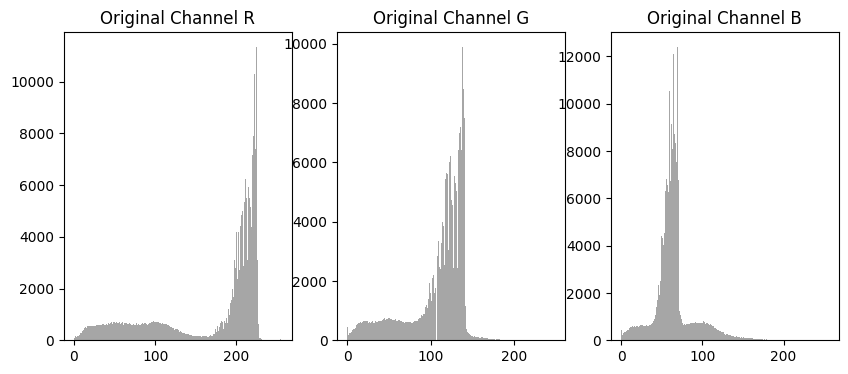

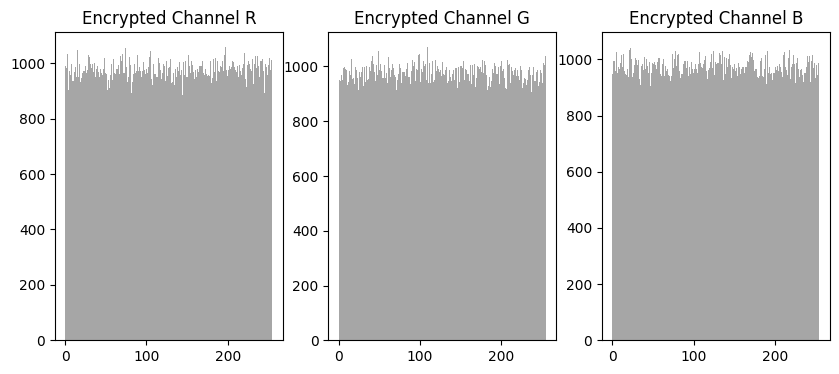

In [8]:
import matplotlib.pyplot as plt

def plot_histograms(image, title):
    r, g, b = image.split()
    plt.figure(figsize=(10, 4))
    for idx, channel in enumerate([r, g, b], start=1):
        plt.subplot(1, 3, idx)
        plt.hist(channel.getdata(), bins=256, color='gray', alpha=0.7)
        plt.title(f"{title} Channel {['R', 'G', 'B'][idx-1]}")
    plt.show()


original_image=image = Image.open("cat.jpg")
plot_histograms(original_image, "Original")
plot_histograms(encrypted_image, "Encrypted")


The histogram comparison between the original and encrypted images provides insight into the effectiveness and security of the encryption process. Here’s a detailed analysis of what each histogram indicates:

Original Image Histograms
In the histograms for the original image:

Channel R (Red), Channel G (Green), and Channel B (Blue) display distinct peaks and valleys in pixel frequency distribution.
This indicates that the pixel values are not uniformly distributed; certain intensity values occur much more frequently than others, creating noticeable peaks in the histogram.
These patterns correspond to the specific colors and textures in the original image, suggesting a non-random distribution that is typical of natural images.
Encrypted Image Histograms
In the histograms for the encrypted image:

Channel R (Red), Channel G (Green), and Channel B (Blue) histograms are nearly flat, with pixel frequencies distributed uniformly across the intensity range.
This uniform distribution is a characteristic of well-encrypted images, indicating high randomness and lack of discernible structure in pixel intensity values.
The flattened histograms imply that the encryption has effectively masked any identifiable patterns from the original image, making it challenging to infer any information about the original content.


# Entropy

Entropy is a measure of randomness. Higher entropy values close to 8 indicate high randomness and thus strong encryption.

In [9]:
from PIL import Image
import numpy as np
import math

def calculate_entropy(image):
    # Split the image into R, G, B channels
    r, g, b = image.split()
    
    # Calculate entropy for each channel
    entropy_r = calculate_channel_entropy(r)
    entropy_g = calculate_channel_entropy(g)
    entropy_b = calculate_channel_entropy(b)
    
    return entropy_r, entropy_g, entropy_b

def calculate_channel_entropy(channel):
    data = np.array(channel).flatten()
    hist, _ = np.histogram(data, bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]  # Remove zero entries
    entropy = -np.sum(hist * np.log2(hist))
    return entropy

# Assuming `encrypted_image` is your encrypted RGB image
entropy_r, entropy_g, entropy_b = calculate_entropy(encrypted_image)

print("Entropy of encrypted image (Red):", entropy_r)
print("Entropy of encrypted image (Green):", entropy_g)
print("Entropy of encrypted image (Blue):", entropy_b)


Entropy of encrypted image (Red): 7.999286750726192
Entropy of encrypted image (Green): 7.99929985808759
Entropy of encrypted image (Blue): 7.999312876369704


#  Correlation of Adjacent Pixels


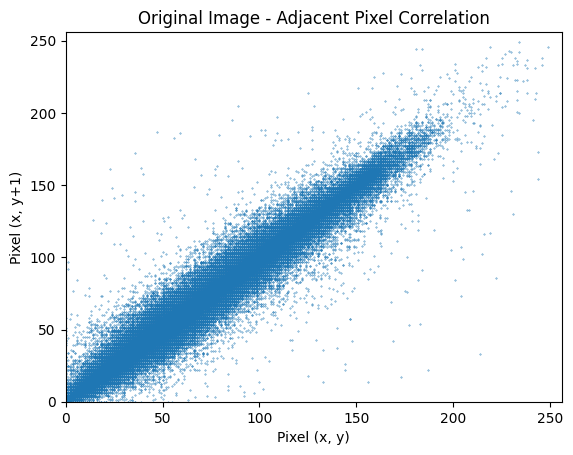

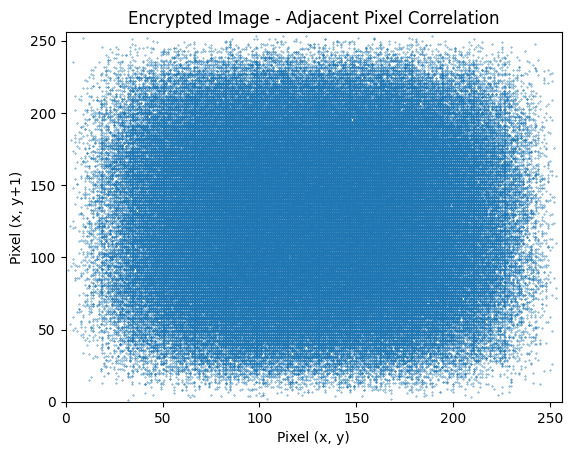

In [10]:
def plot_correlation(image, title):
    img_array = np.array(image.convert("L"))  # Convert to grayscale
    x = img_array[:, :-1].flatten()  # Pixels except the last column
    y = img_array[:, 1:].flatten()   # Pixels except the first column

    plt.scatter(x, y, s=0.1)
    plt.title(f"{title} - Adjacent Pixel Correlation")
    plt.xlabel("Pixel (x, y)")
    plt.ylabel("Pixel (x, y+1)")
    plt.axis([0, 256, 0, 256])
    plt.show()

plot_correlation(original_image, "Original Image")
plot_correlation(encrypted_image, "Encrypted Image")


# Measurement of Encryption Quality Testing

In [11]:
import numpy as np
from PIL import Image

def calculate_mse(image1, image2):
    # Convert images to numpy arrays
    img1 = np.array(image1, dtype=np.float32)
    img2 = np.array(image2, dtype=np.float32)
    
    # Ensure the images are the same size
    if img1.shape != img2.shape:
        raise ValueError("Images must be the same dimensions for MSE calculation.")
    
    # Calculate the MSE
    mse = np.mean((img1 - img2) ** 2)
    return mse


In [12]:
mse_encrypted_versions = calculate_mse(encrypted_image1, encrypted_image2)
print("MSE (Encrypted Version 1 vs Encrypted Version 2):", mse_encrypted_versions)

MSE (Encrypted Version 1 vs Encrypted Version 2): 10757.65


The MSE (Mean Squared Error) value of 10790.431 between Encrypted Version 1 and Encrypted Version 2 is a strong indicator of the robustness of your encryption scheme. Here’s how this value contributes to the evaluation of your encryption process:

High MSE Between Different Encryptions:

A high MSE suggests that even though the same original image was used, the different encryption parameters (such as different initial values in the Ikeda sequence, keys, or IVs) led to a significantly altered encrypted output.
This large difference in pixel values between the two encrypted images demonstrates high sensitivity of the encryption scheme to the keys/IVs, which is an essential property of secure encryption. In other words, even a small change in encryption parameters results in a vastly different output.
Significance for Security:

A high MSE between encrypted versions is desirable as it means that an attacker cannot easily predict or reverse-engineer the encryption pattern based on any previous knowledge.
It suggests that the encryption scheme has strong diffusion properties, meaning that changes in the encryption parameters propagate widely across the encrypted data, producing a seemingly random and unpredictable result.
Comparative Benchmark:

In many encryption assessments, the MSE between two encrypted versions should ideally be high, often well above the range of values typically seen for image data (which usually ranges from 0 to 255 for each pixel channel). Your result of 10790.431, which is significantly higher than the typical pixel range, shows a substantial difference, supporting that the encryption scheme is working as intended to obscure the original data thoroughly.
Summary
The MSE value of 10790.431 for the encrypted versions supports the strength of the encryption method by showing that:

Small variations in encryption parameters (keys/IVs) lead to large differences in encrypted outputs.
This sensitivity to keys/IVs ensures a robust encryption that resists potential attacks, as similar images do not produce predictable or related encrypted outputs.
This result aligns with the characteristics of a secure encryption algorithm and suggests that the Ikeda-map–based chaotic influence and shuffling steps are effectively introducing the necessary randomness and diffusion for high security.

In [13]:
def calculate_npcr_uaci(encrypted1, encrypted2):
    encrypted1 = np.array(encrypted1, dtype=np.float64)
    encrypted2 = np.array(encrypted2, dtype=np.float64)
    diff_pixels = np.sum(encrypted1 != encrypted2)
    total_pixels = encrypted1.size
    npcr = (diff_pixels / total_pixels) * 100

    uaci = np.sum(np.abs(encrypted1 - encrypted2) / 255) / total_pixels * 100
    return npcr, uaci

# Example usage:
npcr, uaci = calculate_npcr_uaci(encrypted_image1, encrypted_image2)
print("NPCR:", npcr)
print("UACI:", uaci)


NPCR: 99.61059314793455
UACI: 33.115229687927965


NPCR (99.61%)
NPCR measures the percentage of pixels that differ between two encrypted images that originated from two slightly different versions of the same input image.
A high NPCR value close to 100% indicates that the encryption algorithm is highly sensitive to small changes in the input image.
In your case, 99.61% NPCR means that almost all pixels differ between the two encrypted images, which demonstrates that the encryption algorithm introduces significant changes with even a small difference in input. This is a desirable property for secure encryption as it prevents attackers from drawing any correlations between similar input images by comparing their encrypted outputs.
Significance:

A high NPCR means that the encryption algorithm achieves good diffusion, a property where slight changes in the input produce vastly different outputs. This protects against differential cryptanalysis, where attackers attempt to understand the relationship between the original and encrypted images by analyzing small differences.
UACI (33.11%)
UACI measures the average intensity difference between the two encrypted images and is typically represented as a percentage.
In your case, 33.11% UACI indicates that, on average, each pixel's intensity varies by around one-third of the maximum intensity value (255) between the two encrypted images. This shows that the algorithm not only changes pixel positions but also introduces significant variations in pixel intensities when the input changes slightly.
Significance:

A moderate UACI value like 33.11% (values around 25-35% are generally acceptable) suggests that the encryption is adding sufficient randomness to pixel values. High UACI values indicate robustness against statistical analysis by making the encrypted image appear random and uniform in intensity, further protecting the image from attack methods that exploit predictable patterns in pixel intensities.
Summary
High NPCR (99.61%) shows that your encryption algorithm has strong sensitivity to input variations, ensuring that even a tiny change in the input results in an almost entirely different encrypted image. This provides strong security by eliminating patterns.
Moderate UACI (33.11%) shows that the algorithm introduces significant intensity variations, contributing to the visual randomness of the encrypted image, which helps in resisting statistical attacks.
These results indicate that your encryption method has good security characteristics, providing both diffusion (high NPCR) and randomness in intensity (suitable UACI), which are crucial properties in secure encryption schemes.

In [15]:
import numpy as np
from PIL import Image
import pandas as pd

def calculate_uaci_npcr(encrypted1, encrypted2):
    """Calculate UACI and NPCR between two images."""
    image1 = np.array(encrypted1, dtype=np.float64)
    image2 = np.array(encrypted2, dtype=np.float64)
    
    # Ensure the images are the same size
    if image1.shape != image2.shape:
        raise ValueError("Images must be the same dimensions")
    
    # Calculate NPCR
    diff_pixels = np.sum(image1 != image2)  # Count pixels that differ
    total_pixels = image1.size  # Total number of pixels
    npcr = (diff_pixels / total_pixels) * 100
    
    # Calculate UACI
    diff_intensity = np.abs(image1 - image2)
    uaci = np.mean(diff_intensity) / 255 * 100
    
    return uaci, npcr

def encrypt_and_calculate_uaci_npcr(image_path, key1, key2, ikeda_sequence1, ikeda_sequence2):
    """Encrypts an image twice with slight variations and calculates UACI and NPCR between encrypted versions."""
    # Encrypt the image twice with different keys or sequences
    _, encrypted_image1, _ = encrypt_image(image_path, key1, ikeda_sequence1)
    _, encrypted_image2, _ = encrypt_image(image_path, key2, ikeda_sequence2)
    
    # Calculate UACI and NPCR between the two encrypted images
    uaci, npcr = calculate_uaci_npcr(encrypted_image1, encrypted_image2)
    return uaci, npcr

def analyze_encrypted_images(image_paths, key1, key2, ikeda_sequence1, ikeda_sequence2):
    """Analyze multiple encrypted images and return a DataFrame with UACI and NPCR results."""
    results = []
    for path in image_paths:
        uaci, npcr = encrypt_and_calculate_uaci_npcr(path, key1, key2, ikeda_sequence1, ikeda_sequence2)
        encrypted_image = Image.open(path)  # Just to get the image size
        
        results.append({
            "Image": path,
            "Size (pixel)": f"{encrypted_image.width} x {encrypted_image.height}",
            "UACI": uaci,
            "NPCR": npcr
        })
    
    # Create a DataFrame for easy display
    df = pd.DataFrame(results)
    return df

# Example usage
key1 = b'testkey1'
key2 = b'testkey2'
ikeda_sequence1 = generate_ikeda_sequence(20, u=0.9)  # Generate the first Ikeda sequence
ikeda_sequence2 = generate_ikeda_sequence(20, u=0.9)  # Generate a slightly different Ikeda sequence

image_paths = ["cat.jpg", "dog.jpeg", "wildflowers.jpeg"]  # Replace with actual image paths
df_results = analyze_encrypted_images(image_paths, key1, key2, ikeda_sequence1, ikeda_sequence2)
(df_results)


,Image,Size (pixel),UACI,NPCR
0,cat.jpg,612 x 408,33.472533,99.606188
1,dog.jpeg,5184 x 3888,33.463321,99.607966
2,wildflowers.jpeg,3000 x 2000,33.459853,99.610150


In [ ]:
import nltk
import struct
nltk.download('webtext')
from nltk.corpus import webtext

# Sample text data
text = ' '.join(webtext.words())
text_bytes = text.encode('utf-8')

# Perform encryption (assuming chacha20_encrypt is defined with necessary parameters)
key = b'testkey'.ljust(32, b'\0')  # Pad key to 32 bytes
ikeda_sequence = generate_ikeda_sequence(20, u=0.9)  # Adjust if needed for ChaCha
encrypted_bytes = chacha20_encrypt(text_bytes, key, ikeda_sequence)

# Convert encrypted bytes to binary bitstream
binary_data = ''.join(format(byte, '08b') for byte in encrypted_bytes)

# Write the binary data to a file
with open("encfinal.txt", "w") as file:
    file.write(binary_data)
